&nbsp;

# 프로젝트 : 커스텀 프로젝트 직접 만들기


&nbsp;

실습 코드에서 수행해 본 내용을 토대로, GLUE dataset의 `MNLI` task 를 수행하는 프로젝트를 커스텀 프로젝트 형태로 진행해 보도록 하겠다.


- Dataset : [General Language Understanding Evaluation(GLUE) Benchmark Dataset](https://gluebenchmark.com/)


- Task : MNLI - 두 문장의 관계 판단(entailment, contradiction, neutral)


프로젝트 가이드에 따르면, 노드 실습 부분에서 사용한 BERT 모델을 사용하면 학습이 제대로 되지 않는다고 한다.

[Hugging Face](https://huggingface.co/models) 에서는 여러 모델들을 검색 할 수 있는데, 여기에서

tensorflow 와 해당 모델(MNLI)에 대한 Task 를 검색하면 사용할 수 있는 모델들이 나온다.

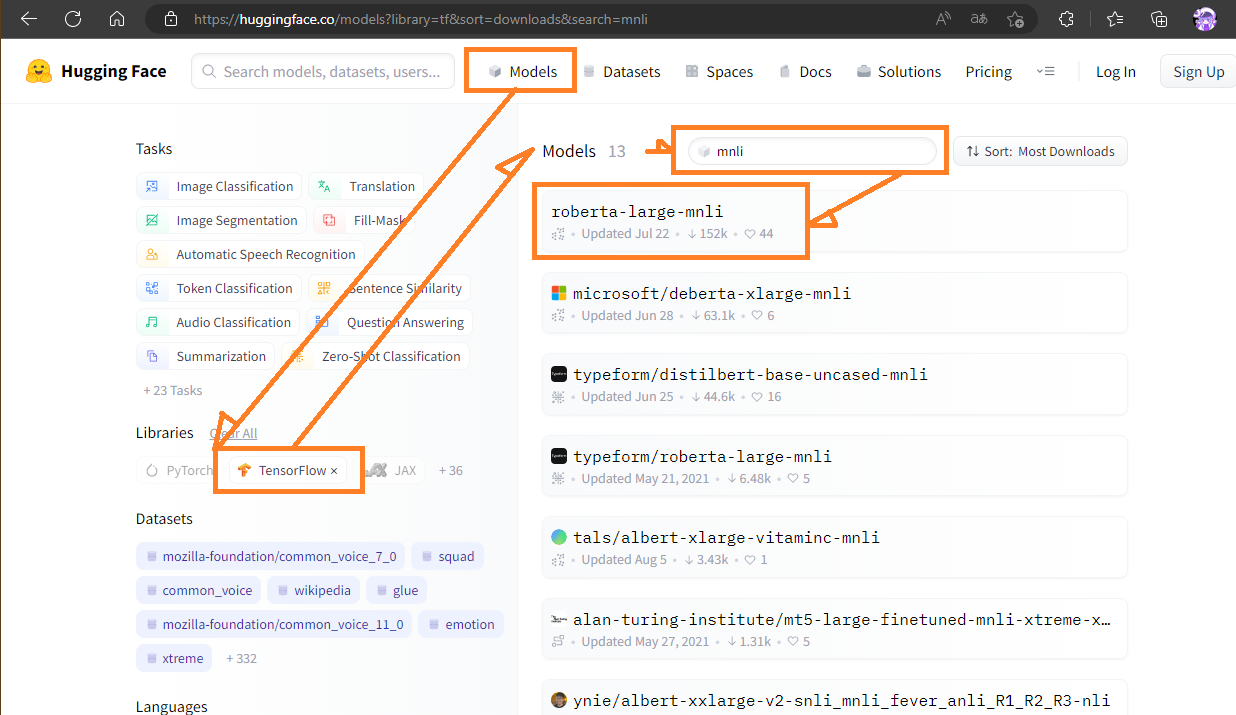<br>
[Hugging Face 에서는 다양한 모델들을 검색할 수 있다.]

여기에서는 프로젝트 가이드에 따라 모델을 검색하고, 

그 결과 목록에서 가장 다운로드 수가 많은 roberta-large-mnli 모델을 선택하여 사용하도록 하겠다.

그 후 선택한 모델의 tokenizer 와 해당 모델에 대한 task, 모델의 정보를

[Hugging Face - Transformers](https://huggingface.co/transformers/index.html) 에서 찾아 프로젝트를 완성해 나가도록 한다.

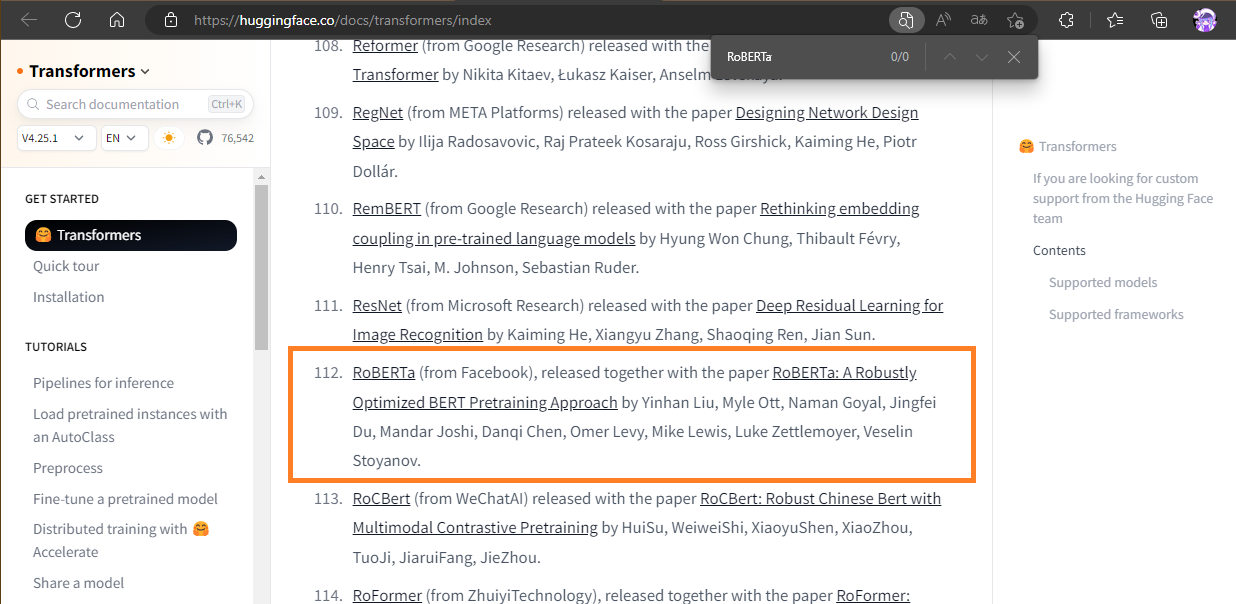

- 최종적으로는, roberta-large-mnli 모델은 메모리 이슈로 인하여 사용하지 않았다.<br>
같은 검색방법을 통해, 다른 모델을 선택하여 진행하였다.

&nbsp;

### 라이브러리 버전을 확인해 봅니다.

<hr>

In [1]:
import tensorflow
import numpy
import transformers
import argparse

print("tensorflow version :", tensorflow.__version__)
print("numpy version :", numpy.__version__)
print("transformers version :", transformers.__version__)
print("argparse version :", argparse.__version__)


## Use Huggingface framework
import os
import numpy as np
from argparse import ArgumentParser
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import BertTokenizer, DistilBertTokenizer, TFBertForPreTraining, TFDistilBertForSequenceClassification, AutoConfig
from dataclasses import asdict
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures


## Use Hugging Face Datasets
import datasets
from datasets import load_dataset


## Use Hugging Face Auto Classes
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification


## Use Hugging Face Trainer
from transformers import Trainer, TrainingArguments
from datasets import load_metric


## tqdm
from tqdm.notebook import tqdm


print("tensorflow_datasets version :", tfds.__version__)

print("✔️")

tensorflow version : 2.6.0
numpy version : 1.21.4
transformers version : 4.11.3
argparse version : 1.1
tensorflow_datasets version : 4.4.0
✔️


&nbsp;

### STEP 1. mnli 데이터셋을 분석해 보기

<hr>

> `tensorflow-datasets` 를 이용하여 `glue/mnli` 를 다운로드하려면 `tensorflow-datasets` 라이브러리 버전을 올려야 합니다.
>
> $ pip install tensorflow-datasets -U
>
> 위 명령어를 통해 라이브러리 업그레이드를 진행해 주세요!



tensorflow_datasets에서 제공하는 GLUE 데이터셋을 불러오도록 하자.

In [2]:
## data, info = tfds.load('glue/mrpc', with_info=True)
data, info = tfds.load('glue/mnli', with_info=True)
info.splits['train'].num_examples

INFO:absl:Load dataset info from /aiffel/tensorflow_datasets/glue/mnli/2.0.0
INFO:absl:Reusing dataset glue (/aiffel/tensorflow_datasets/glue/mnli/2.0.0)
INFO:absl:Constructing tf.data.Dataset glue for split None, from /aiffel/tensorflow_datasets/glue/mnli/2.0.0


392702

총 392702 개의 샘플이 있는 것으로 보인다.

&nbsp;

데이터들을 좀 더 살펴보자.

In [3]:
info

tfds.core.DatasetInfo(
    name='glue',
    full_name='glue/mnli/2.0.0',
    description="""
    GLUE, the General Language Understanding Evaluation benchmark
    (https://gluebenchmark.com/) is a collection of resources for training,
    evaluating, and analyzing natural language understanding systems.
    """,
    config_description="""
    The Multi-Genre Natural Language Inference Corpus is a crowdsourced
    collection of sentence pairs with textual entailment annotations. Given a premise sentence
    and a hypothesis sentence, the task is to predict whether the premise entails the hypothesis
    (entailment), contradicts the hypothesis (contradiction), or neither (neutral). The premise sentences are
    gathered from ten different sources, including transcribed speech, fiction, and government reports.
    We use the standard test set, for which we obtained private labels from the authors, and evaluate
    on both the matched (in-domain) and mismatched (cross-domain) section. We a

info 는 데이터에 대한 설명으로 보인다.

glue/mnli 의 info 와 관련한 내용은 Tensorflow 공식 문서에서도 확인이 가능하다.

<hr>

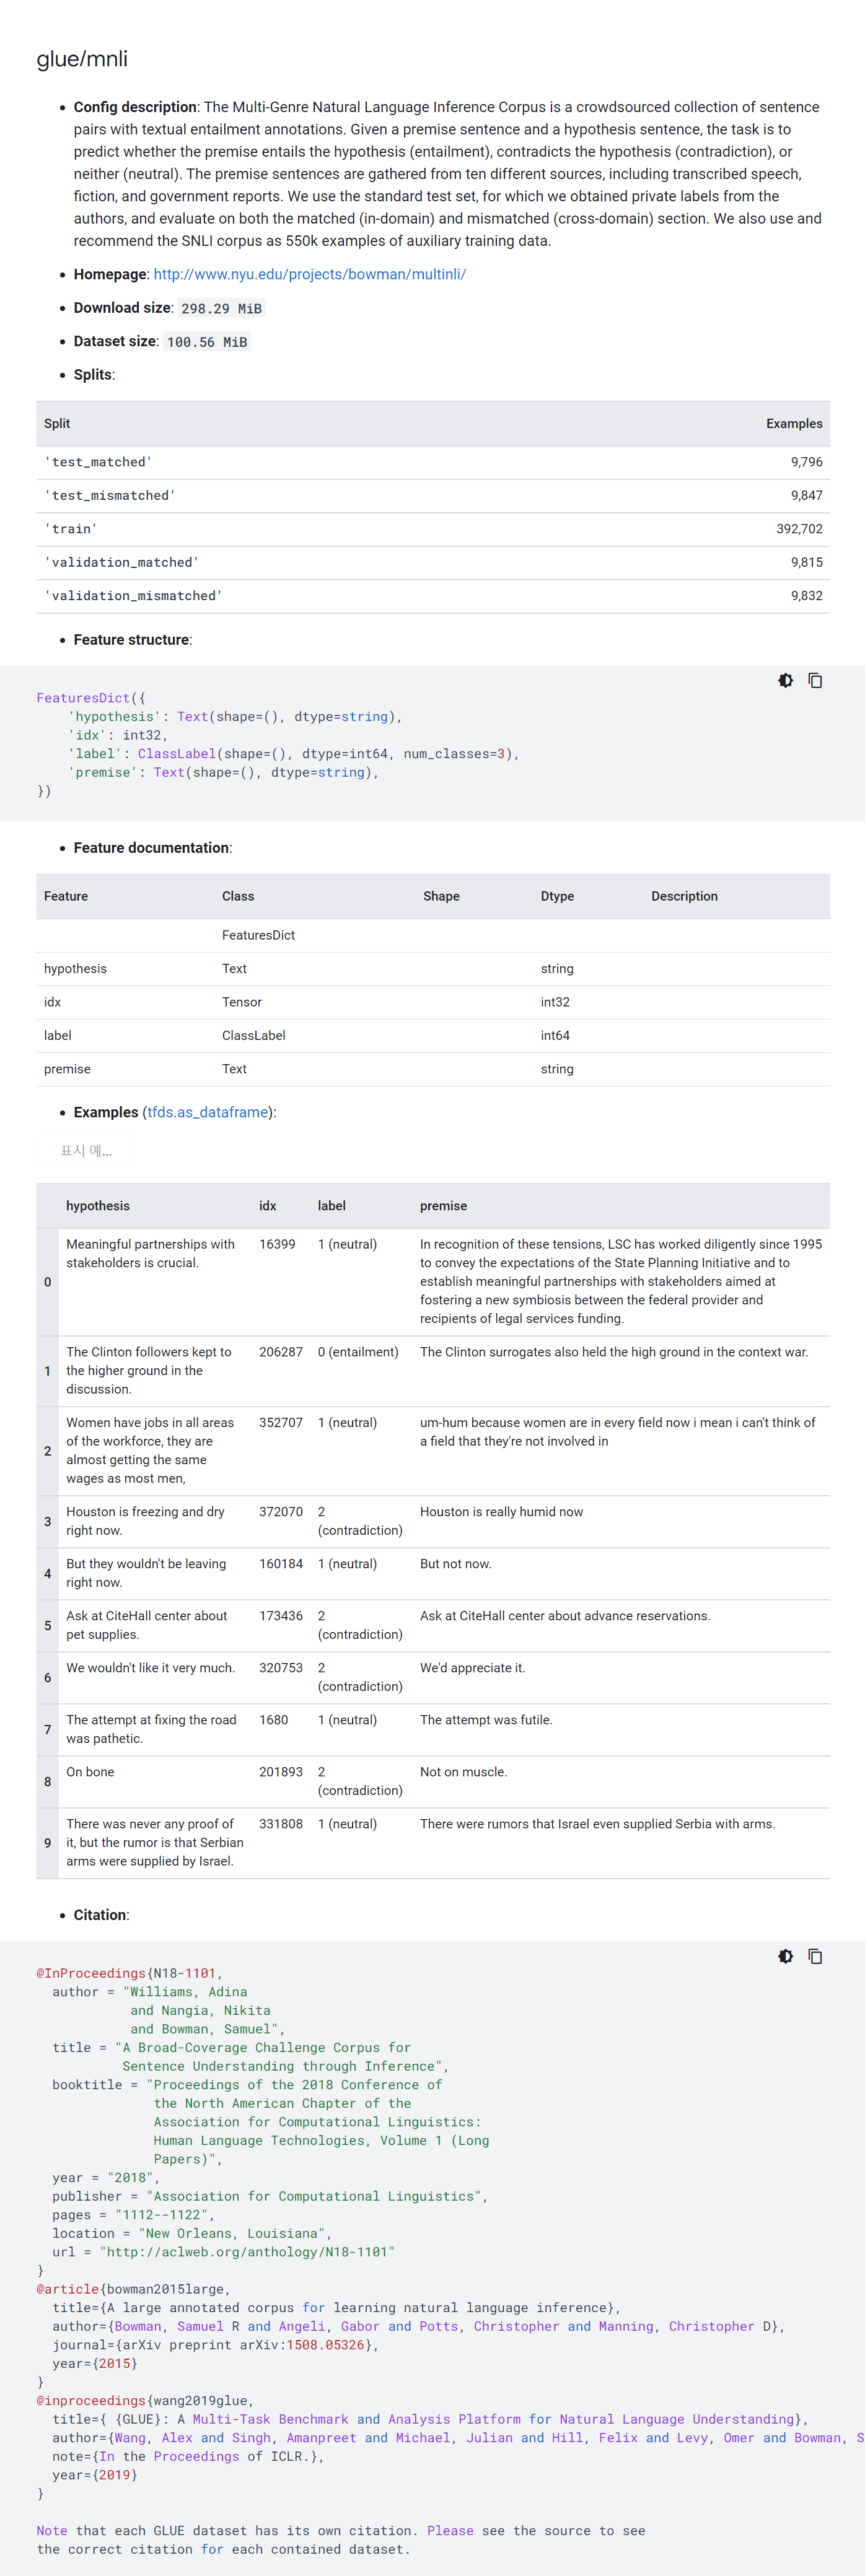<br>
[[TensorFlow Datasets - glue/mnli - (https://www.tensorflow.org/datasets/catalog/glue#gluemnli)]](https://www.tensorflow.org/datasets/catalog/glue#gluemnli)

<hr>

&nbsp;

데이터 data는 어떤 것인지 알아보자.

In [4]:
data

{'train': <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>,
 'validation_matched': <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>,
 'validation_mismatched': <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>,
 'test_matched': <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>,
 'test_mismatched': <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>}

In [5]:
type(data)

dict

data 의 데이터타입은 딕셔너리이다.

In [6]:
data.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

데이터안에 어떤 항목들이 정의되어 있는지 확인 할 수 있다.

In [7]:
data.items()

dict_items([('train', <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>), ('validation_matched', <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>), ('validation_mismatched', <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>), ('test_matched', <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>), ('test_mismatched', <PrefetchDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>)])

요소들을 확인하면 위와 같다.

이전에 데이터의 갯수를 확인 해 보았었던 아래의 코드를 한번 활용해 보자.

In [8]:
info.splits["train"].num_examples

392702

In [9]:
print("train :", info.splits["train"].num_examples)
print("validation_matched :", info.splits["validation_matched"].num_examples)
print("validation_mismatched :", info.splits["validation_mismatched"].num_examples)
print("test_matched :", info.splits["test_matched"].num_examples)
print("test_mismatched :", info.splits["test_mismatched"].num_examples)

train : 392702
validation_matched : 9815
validation_mismatched : 9832
test_matched : 9796
test_mismatched : 9847


각각의 데이터를 확인 해 볼 수 있다.

train 은 아무래도 훈련용 데이터로 보인다.

validation_??? 은 validation 용 데이터로 보인다. matched / mismatched 내용은 MNLI - 두 문장의 관계 판단 에서의 매칭 관계로 보인다.

test_??? 도 마찬가지로 test 에서 사용할 데이터로 보인다. 각각의 매칭관계로 구분되어 있는 것으로 보인다.

- 훈련용 데이터는 392,702 건

- 검증용 데이터는 부합 9815 건, 부조합 9832 건

- 테스트용 데이터는 부합 9796 건, 부조합 9847 건 

의 수량을 가지고 있다.

&nbsp;

데이터의 실제 내용을 확인 해 보자.

`data` 는 `tf.data.Dataset`을 상속받은 클래스의 형태일 것이다.

우선 1개의 데이터만 가져다가 어떻게 생겼는지 확인해 보자.

In [10]:
exs = data['train'].take(1)

In [11]:
type(exs)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [12]:
exs

<TakeDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>

In [13]:
for ex in exs:
    ex_idx = ex["idx"]
    ex_premise = ex["premise"]    ## 전제
    ex_hypothesis = ex["hypothesis"]    ## 가설
    ex_label = ex["label"]


    print("ex_idx :", ex_idx, "        ", "ex_label :", ex_label)
    print("─" * 32)
    print(" ▷ ex_premise (전제) :", ex_premise)
    print()
    print(" ▷ ex_hypothesis (가설) :", ex_hypothesis)
    print()
    

ex_idx : tf.Tensor(16399, shape=(), dtype=int32)          ex_label : tf.Tensor(1, shape=(), dtype=int64)
────────────────────────────────
 ▷ ex_premise (전제) : tf.Tensor(b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', shape=(), dtype=string)

 ▷ ex_hypothesis (가설) : tf.Tensor(b'Meaningful partnerships with stakeholders is crucial.', shape=(), dtype=string)



원하는 정보가 아닌 내용이 많아서 보기에 간단하지 않은 상황이다.

In [14]:
ex_premise

<tf.Tensor: shape=(), dtype=string, numpy=b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'>

In [15]:
ex_premise.numpy()

b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'

위와 같이 numpy() 등의 메서드를 사용하면 원하는 정보를 얻을 수 있는 것으로 보인다.

그렇다면 이전의 출력문을 다시 정의해보면 아래와 같다.

In [16]:
## 3개만 가져와 보겠다.
exs = data['train'].take(5)

for ex in exs:
    ex_idx = ex["idx"]
    ex_premise = ex["premise"]    ## 전제
    ex_hypothesis = ex["hypothesis"]    ## 가설
    ex_label = ex["label"]

    
    print("ex_idx :", ex_idx.numpy(), "        ", "ex_label :", ex_label.numpy())
    print("─" * 32)
    print(" ▷ ex_premise (전제) :", ex_premise.numpy())
    print()
    print(" ▷ ex_hypothesis (가설) :", ex_hypothesis.numpy())
    print("\n\n")
    

ex_idx : 16399          ex_label : 1
────────────────────────────────
 ▷ ex_premise (전제) : b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'

 ▷ ex_hypothesis (가설) : b'Meaningful partnerships with stakeholders is crucial.'



ex_idx : 206287          ex_label : 0
────────────────────────────────
 ▷ ex_premise (전제) : b'The Clinton surrogates also held the high ground in the context war.'

 ▷ ex_hypothesis (가설) : b'The Clinton followers kept to the higher ground in the discussion. '



ex_idx : 352707          ex_label : 1
────────────────────────────────
 ▷ ex_premise (전제) : b"um-hum because women are in every field now i mean i can't think of a field that they're not involved in"

 ▷ ex_hypothesis (가설) : b'Women have jobs in all areas of the

위와 같은 내용을 확인할 수 있다.

이렇게 데이터 분석을 마치고 다음 Step 으로 넘어가자.

&nbsp;

### STEP 2. `MNLIProcessor` 클래스 구현하기

<hr>


노드 실습 부분에서는, `Huggingface transformers` 에서 task별로 데이터셋을 가공하는 일반적인 클래스 구조인 `Processor` 의 활용에 대해 다루었었다.

해당 내용에서 `DataProcessor` 클래스는, 추상클래스인 `Processor` 를 한번 상속 받은 후, `Sequence Classification task` 를 수행하는 모델의 `Processor` 추상클래스임을 설명하고 있었다.

여기에서도, 우선적으로 추상클래스 DataProcessor 를 통해 상속받은, MNLI Task 를 수행하는 모델인 MNLIProcessor 를 구현하도록 하겠다.

────────────────────────

이러한 관계를 UML 다이어그램으로 나타내면 아래의 도식으로 나타낼 수 있다.

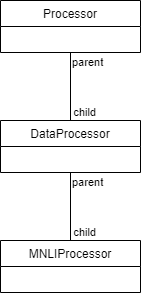

&nbsp;

In [17]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    ## tfds_map는 label을 가공하는 메소드인데, 이미 숫자로 잘 가공된 label이기 때문에 특별한 변화가 필요 없다.
    ## 상속받은 클래스에서 오버라이드 하지 않고, 현재의 구현을 그대로 사용 할 것이다.
    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

print("✔️")

✔️


위의 추상클래스 상태에서는 `NotImplementedError` 를 발생시키는 메소드들이 포함되어 있다.

이 메소드들을 오버라이드해서 구현을 한다면 실제 사용 가능한 클래스를 얻을 수 있다.

아래는 노드 실습 부분에서 다루었던, 'MRPC' 데이터셋을 처리하여 모델에 입력할 수 있도록 정리해주는 MRPCProcessor 클래스를 참고하여,

MNLI task를 다룰 수 있도록 변경하여 구현한 `MNLIProcessor` 클래스이다.

In [18]:

## MNLIProcessor 클래스
class MnliProcessor(DataProcessor):    ## DataProcessor 에서 상속 받음
    
    """Processor for the MNLI data set (GLUE version)."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    ## Raw Dataset를 Annotated Dataset으로 변환'하는 역할 수행
    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["premise"].numpy().decode("utf-8"),    ## 전제
            tensor_dict["hypothesis"].numpy().decode("utf-8"),    ## 가설
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""

        ## TensorFlow 공식 문서
        ## 〔TensorFlow Datasets - glue/mnli - Examples(표시예)〕 에서는
        ## label 에 대해 아래와 같이 정의하고 있다.
        ## --------------------------------------------------
        ## 0 (entailment)
        ## 1 (neutral)
        ## 2 (contradiction)
        ## MRPC 참조시에 "0", "1" 의 문자열로 구분을 하고 있었어서,   >> return ["0", "1"]
        ## 여기에서도 "0", "1", "2" 의, 문자열 형식을 사용하였다.
        ## --------------------------------------------------
        ## 0 entailment: 가설은 전제에서 따른다.
        ## 1 neutral: 가설과 전제는 관련이 없다.
        ## 2 contradiction: 가설은 전제와 모순된다.
        
        return ["0 (entailment)", "1 (neutral)", "2 (contradiction)"]
    

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = None if set_type == "test" else line[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
            
        return examples

print("✔️")

✔️


실제 label 을 확인하여, Classification 문제를 잘 정의하고 있는지 확인해보자.

In [19]:
processor = MnliProcessor()
label_list = processor.get_labels()
label_list

['0 (entailment)', '1 (neutral)', '2 (contradiction)']

각각의 label 을 잘 정의하고 있다.

더 테스트해보자.

루브릭 평가 지표와 관련하여, MnliProcessor 클래스를 정상적으로 구현하였다면,

이하의 코드블럭에서, Processor 클래스에 대한 1개 이상의 example 단위테스트를 정상적으로 진행할 수 있을 것이다.

In [20]:
examples = data["train"].take(1)

for example in examples:
    print('------원본데이터------')
    print(example)  
    example = processor.get_example_from_tensor_dict(example)
    print('------processor 가공데이터------')
    print(example)

------원본데이터------
{'hypothesis': <tf.Tensor: shape=(), dtype=string, numpy=b'Meaningful partnerships with stakeholders is crucial.'>, 'idx': <tf.Tensor: shape=(), dtype=int32, numpy=16399>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'premise': <tf.Tensor: shape=(), dtype=string, numpy=b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'>}
------processor 가공데이터------
InputExample(guid=16399, text_a='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', text_b='Meaningful partnerships with stakeh

위와 같이, Processor는 '**Raw Dataset를 Annotated Dataset으로 변환**'하는 역할을 한다.

항목별로 text_a, text_b, label 등의 annotation이 포함된 InputExample로 변환되어 있음을 알 수 있다.

&nbsp;

지금까지 tensorflow datasets을 이용해서 데이터를 확인해보았다. 

이 방법보다 쉽고 간편한 방법이 있는데, 바로 Huggingface에서 제공하는 datasets를 이용하는 방법이다.

Huggingface datasets을 이용하는 방법은 아래와 같다.

In [21]:
huggingface_mnli_dataset = load_dataset("glue", "mnli")
print(huggingface_mnli_dataset)

  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


데이터 내용이 거의 같다는 것을 확인 할 수 있다.

아무튼 다음 Step 으로 가보자.

&nbsp;

### STEP 3. 위에서 구현한 processor 및 Huggingface에서 제공하는 tokenizer를 활용하여 데이터셋 구성하기

<hr>


Processor를 통해 Framework을 활용하여 데이터셋을 가공하는 작업을 잘 진행했다면 이미 절반 이상 진행한 상태로 볼 수 있다.

NLP 모델링의 핵심을 이루는 Tokenizer와 Model은 framework에서 이미 잘 만들어져 있는 것을 쉽게 가져다 쓸 수 있기 때문이다.

이전 스텝에서 만든 `MnliProcessor` 클래스와 framework를 결합시켜 나가는 과정을 진행해보자. 

&nbsp;

Pretrained model 기반의 NLP framework를 사용할 때 가장 중요한 두 가지 클래스는 Model과 Tokenizer라고 할 수 있다. 

그리고 그 둘은 밀접한 관련이 있는데, 파라미터 구조가 동일한 Model이라 하더라도 Tokenizer가 다르거나

Tokenizer 내의 Dictionary가 달라지면 사실상 완전히 다른 모델이 된다.

그리고 Tokenizer는 어떤 언어를 다루느냐 하는 코퍼스 데이터셋에 따라서도 달라진다.

tokenizer 를 직접 명시하여 내가 사용할 것을 지정해 주거나, AutoTokenizer를 사용하여

이미 구비된 model에 알맞은 tokenizer를 자동으로 불러올 수 있다.

이때 유의할 점은, **model을 사용할 때 명시했던 것과 동일한 ID로 tokenizer를 생성** 해야 한다는 점이다.

루브릭 조건에 따라 BERT Tokenizer 를 사용하도록 하겠다. Tokenizer 관련 내용은 이전 노드의 학습 파트에서 다루고 있다.

그리고 유의사항으로, 모델에 명시한 ID 와 토크나이저 생성시에도 같은 ID 를 사용하여야 한다고 하였다.

여기서는 HuggingFace 에서 제공하는 것들 중에, 이하의 ID 를 선택하여 사용하도록 하겠다.

일반적인 기본 모델 정도로 보면 될 것이라고 생각한다.

 - **bert-base-uncased** : BERT 모델인데, 108MB 파라미터의 기본 모델이면서, 코퍼스는 영문 대소문자 구분을 없앴다(전체 소문자화)

토크나이저, 모델을 선택한다.

노드 실습 16-4 에서 Tokenizer 생성 부분을 참고하여 토크나이저 모델을 선택하려는데,

여기서는 TF… 로 시작하는 것을 사용하고자 한다. 

HuggingFace - Transformers 공식 문서의 BERT Tokenizer 부분을 알아보다 [TFBertTokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertTokenizer) 부분을 참고하였다.

[코드 예시](https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertTokenizer.from_pretrained.example) 부분을 참고하여 토크나이저를 만들면 아래와 같이 사용할 수 있다.



In [22]:
# from transformers import TFBertTokenizer

# bert_toknizr = TFBertTokenizer.from_pretrained("bert-base-uncased")
# bert_model = TFBertForPreTraining.from_pretrained("bert-base-uncased")

하지만 import 실패하여, 이전에 사용하려 했던 기본 Tokenizer 를 사용하도록 하겠다.

In [23]:
bert_toknizr = BertTokenizer.from_pretrained("bert-base-uncased")

model 과 토크나이저는, 같은 ID 를 사용하도록 하였으니, 모델도 미리 사용하도록 하겠다.

모델의 경우도 TF… 로 시작하는, [TFBertForSequenceClassification](https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertForSequenceClassification) 을 선택해보았다.

본 프로젝트에 앞선 Lecture 노드에서와 마찬가지로 Sequence Classification task를 수행할 것이기 때문이다.

공식문서에 따르면, `TFBertForSequenceClassification` 는 `TFPreTrainedModel` 에서 상속되었다고 한다.

> Bert Model transformer with a sequence classification/regression head on top (a linear layer on top of the pooled output) e.g. for GLUE tasks.
>
> This model inherits from TFPreTrainedModel.

그리고 GLUE tasks 에서의 분류등에 사용하기에 괜찮아 보인다.

마찬가지로 코드 예시를 HuggingFace - Transformers 공식 문서에서 제공하고 있었다.

 - [HuggingFace - Transformers - TFBertForSequenceClassification Example Code](https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertForSequenceClassification.call.example)


위의 코드 예시 에서는 토크나이저로 BertTokenizer 를 사용하고 있다. 
 
아무래도 이전에 실패한 TFBertTokenizer 는 사용 안한 상태인 이대로가 좋은 것 같다.

In [24]:
from transformers import TFBertForSequenceClassification

bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


위와 같이 BERT `tokenizer` 와 그를 위한 `model` 을 생성했다.


&nbsp;

앞서 BERT 모델 외에 하나의 모델을 더 준비해두었었다.

여기에서 미리 토크나이저와 모델을 따로 준비해 두도록 하겠다.

다만 이번에는 `Huggingface Auto Classes` 를 이용하는 방법을 사용하겠다.

노드 학습 부분에서는 HuggingFace Auto Classes 에 대하여 아래와 같이 설명하고 있다.

~~~
AutoTokenizer와 AutoModel은 Huggingface에서 지원하는 Auto Class입니다.

Auto class는 from_pretrained 메소드를 이용해 pretrained model의 경로 혹은 이름만 안다면 자동으로 생성하는 방법입니다.

즉 bert를 사용할때 BertTokenizer, RoBERTa를 사용할때 RobertaTokenizer를 사용하게 되는데 AutoTokenizer를 이용하면 자동으로 BERT모델은 BERT로 RoBERTa모델은 RoBERTa로 바꿔줍니다.

model도 마찬가지입니다. 다만 model의 경우 AutoModel을 그대로 사용하기보다 특정 task를 지정하는 방식인 AutoModelForSequenceClassification을 사용하는걸 권장드립니다.

Auto class는 다양한 모델에 자동으로 맞출 수 있기 때문에 특정 task와 dataset이 주어져있는 경우 모델을 다양하게 넣어 실험할 수 있습니다.

그렇기에 Auto class를 유용하게 활용하는 것을 추천합니다.
~~~

그럼 아래의 코드에서 처럼 간단하게, 토크나이저와 모델을 준비하도록 하자.

In [25]:
robert_toknizr = AutoTokenizer.from_pretrained(
    "huggingface/distilbert-base-uncased-finetuned-mnli")

robert_model = AutoModelForSequenceClassification.from_pretrained(
    "huggingface/distilbert-base-uncased-finetuned-mnli", num_labels = 3)

이하의 모델들을 사용해 보았으나, 

CUDA 메모리 오류를 비롯하여, 정상적으로 동작하지 않거나,

60％ 정도 진행중이던 train 과정중에 오류와 함께 중단이 되는 등 문제들이 계속 발생하였다.

roberta-large-mnli

tals/albert-xlarge-vitaminc-mnli

course5i/SEAD-L-6_H-384_A-12-mnli

결국 이 모델들은 사용할 수 없다고 판단했다.

roberta-large-mnli 모델은 비슷한 실행 환경에서 프로젝트를 진행하는 다른 교육생들도 모두 메모리 문제를 겪었다고 한다.

이 프로젝트 진행과정에서, bert 보다 나을 것이라는 가설에 따라 roberta-large-mnli 모델을 채택하였었는데,

그 이유와 함께, HuggingFace 에서 찾아본 모델들 중에, Most Downloads / Most Likes 모두 상위권이라는 이유도 있었다.

아무래도 많이 사용되고, 좋다고 평가된 모델이라 쉽게 진행 할 수 있을거라 생각했었다.

그러나, 여러 방법으로 시도해 보았으나, 도무지 실행 환경의 메모리 이슈 때문에, 진행이 더이상 불가능 하다고 판단했다.

그리고 4 번째로 선택한 `huggingface/distilbert-base-uncased-finetuned-mnli` 모델을 사용하여

epoch 1 테스트로 실행 하였을때, 이상 없이 실행 되는 것을 확인하였다.

다른 교육생들의 이야기를 빌리자면, `typeform/distilbert-base-uncased-mnli` 모델도 실행에 문제가 없다고 들었다.

&nbsp;

이제 processor와 tokenizer, 원본 데이터셋을 결합하여 model에 입력할 데이터셋을 생성하자.

`_glue_convert_examples_to_features()` 함수는 processor가 생성한 example을 tokenizer로 인코딩하여 feature로 변환하는 역할을 한다.

In [26]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
#         print("Using label list %s" % (label_list))

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    for i in tqdm(range(len(examples))):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

#     for i, example in enumerate(examples[:5]):
#         print("*** Example ***")
#         print("guid: %s" % (example.guid))
#         print("features: %s" % features[i])

    return features

print("✔️")

✔️


`tf_glue_convert_examples_to_features()` 함수는 내부적으로 `_glue_convert_examples_to_features()` 를 호출해서
 
 얻은 feature를 바탕으로 `tf.data.Dataset` 을 생성하여 반환한다.

In [27]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None, output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

print("✔️")

✔️


`tf_glue_convert_examples_to_features()` 함수는 최종적으로 모델에 전달될 `tf.data.Dataset` 인스턴스를 생성한다.

이 `tf_glue_convert_examples_to_features()` 함수를 사용하여, 데이터셋을 만드는 함수를 정의하도록 하겠다.

매개변수로는 3 종류의 데이터와, 토크나이저, 프로세서를 사용하면 될 것이다.

train 셋에서는 데이터셋 배치를 지정할 때 repeat(2) 를 지정하므로, 매개변수에 repeat 구분을 위한 자리도 추가했다.

In [28]:
def datasetter(dat, tok, proc, repeat=False):
    ds: tf.data.Dataset = tf_glue_convert_examples_to_features(dat, tok, max_length=128, processor=proc)
    ds_batch = ds.shuffle(100).batch(16)
        
    if (repeat):
        ds_batch = ds_batch.repeat(2)
    
    return ds, ds_batch

데이터 구성을 살펴보면,

- train : 392702

- validation_matched : 9815

- validation_mismatched : 9832

- test_matched : 9796

- test_mismatched : 9847

위와 같은 구성을 가지고 있는데, matched, mismatched 의 경우 어떻게 처리해야 할 지를 확인해보았다.

[링크](https://inmoonlight.github.io/2019/12/22/GLUE-benchmark/#multi-genre-nli-corpus-mnli) benchmark의 내용에 따르면, 

~~~
testset은 CoLA처럼 matched(in-domain)와 mismatched(cross-domain)로 구성되었다. 
mismatched에는 9/11, FACE-TO-FACE, LETTERS, OUP, VERBATIM처럼 training set에는 없는 domain이 포함되어 있다.
~~~

없는 도메인이라 하여도 크게 관계가 없을 것이라고 예상하기 때문에, 여기서는 matched 와 mismatched를 합쳐서 사용해 보고자 한다.

어차피 추론의 라벨에 따르면 0 (entailment), 1 (neutral), 2 (contradiction) 의 값을 가지게 될 것이므로,

in-domain, cross-domain 상관없이 사용하여도 아무런 문제가 없을 것이다.

토크나이저가 다르니… 일단 모델에 따라 준비를 따로 해야 하겠다.

In [29]:
# import warnings
# warnings.filterwarnings(action='ignore')

## 의미없는 메시지 반복 출력하는 부분 제거
## https://github.com/huggingface/transformers/issues/14285
transformers.logging.set_verbosity_error()

bert_train, bert_train_batch = datasetter(
    data["train"], 
    bert_toknizr, processor, repeat=True)

bert_valid, bert_valid_batch = datasetter(
    data["validation_matched"].concatenate(data["validation_mismatched"]), 
    bert_toknizr, processor)

bert_test, bert_test_batch = datasetter(
    data["test_matched"].concatenate(data["test_mismatched"]), 
    bert_toknizr, processor)

## ─────────────────────────────────

# robert_train, robert_train_batch = datasetter(
#     data["train"], 
#     robert_toknizr, processor, repeat=True)

# robert_valid, robert_valid_batch = datasetter(
#     data["validation_matched"].concatenate(data["validation_mismatched"]), 
#     robert_toknizr, processor)

# robert_test, robert_test_batch = datasetter(
#     data["test_matched"].concatenate(data["test_mismatched"]), 
#     robert_toknizr, processor)

  0%|          | 0/392702 [00:00<?, ?it/s]

  0%|          | 0/19647 [00:00<?, ?it/s]

  0%|          | 0/19643 [00:00<?, ?it/s]

In [30]:

## 

&nbsp;

이전 스텝에서, HuggingFace 이용하여 데이터셋을 불러오는 기능만 확인 해 보고,

데이터는 실제로 사용하지 않겠다고 한 코드블럭이 있다. (아래와 같다)

~~~python
huggingface_mnli_dataset = load_dataset("glue", "mnli")
print(huggingface_mnli_dataset)
~~~

HuggingFace 를 사용하면, 토크나이징은 간편하게 진행 할 수 있다.

토크나이징은 transform이라는 함수를 만들고 이전에 만들어두었던 Tokenizer를 사용하는데,

이때 dataset의 형태를 확인하고 바꿀 대상을 지정해야 한다.

노드 실습 부분에서 다룬 `mrpc`의 경우 sentence1, sentence2가 토크나이징할 대상이었고,

`data["sentence1"]`, `data["sentence2"]` 로 인덱싱해서 지정했었다.

여기서 다루는 **`mnli`** 의 경우 premise, hypothesis 가 토크나이징 할 대상이므로,

`data["premise"]` , `data["hypothesis"]` 로 인덱싱해서 지정하겠다.

truncation은 특정 문장이 길어 모델을 다루기 힘들어 질 수 있으므로 짧게 자르는 것을 의미한다.

한 번 확인해보자.

In [31]:
def transform(data):
    return robert_toknizr(
        data["premise"],
        data["hypothesis"],
        truncation = True,
        padding = "max_length",
        return_token_type_ids = False, 
    )

examples = huggingface_mnli_dataset["train"][:3]
examples_transformed = transform(examples)

print(examples)
print(examples_transformed)

{'premise': ['Conceptually cream skimming has two basic dimensions - product and geography.', 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him', 'One of our number will carry out your instructions minutely.'], 'hypothesis': ['Product and geography are what make cream skimming work. ', 'You lose the things to the following level if the people recall.', 'A member of my team will execute your orders with immense precision.'], 'label': [1, 0, 0], 'idx': [0, 1, 2]}
{'input_ids': [[101, 17158, 2135, 6949, 8301, 25057, 2038, 2048, 3937, 9646, 1011, 4031, 1998, 10505, 1012, 102, 4031, 1998, 10505, 2024, 2054, 2191, 6949, 8301, 25057, 2147, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

이러한 데이터셋을 한번에 토크나이징 할 때는 주로 map 기법을 사용한다.

map 을 사용하게 되면 Data dictionary 에 있는 모든 데이터들에 빠르게 적용 시킬 수 있다.

map 을 사용해 토크나이징을 진행할 때에는 batch 를 적용해야 하므로 batched=True 를 지정한다.

In [32]:
encoded_dataset = huggingface_mnli_dataset.map(transform, batched=True)

  0%|          | 0/393 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

5개의 데이터 (train 과 matched / mismatched 로 나뉜 validation, test 데이터) 토크나이징을 진행하였다.

물론 앞서 구성한 데이터셋과 다르기 때문에, 사용하지는 않을 것이다.

&nbsp;

### STEP 4. model을 생성하여 학습 및 테스트를 진행해 보기

<hr>

**▶ tf.keras.model 을 활용한 학습**

`model.fit()` 을 이용한 학습을 진행해보자.

In [33]:
num_classes = len(processor.get_labels())

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [34]:
print(num_classes)

3


모델을 컴파일 하고, summary 를 살펴보자.

In [35]:
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


약 1억개의 파라미터를 갖고 있는것을 확인할 수 있다.

학습은 이미 잘 훈련된 BERT 모델을 가져다가 fine-tuning하는 작업이다.

편의상 3 Epoch 만 진행한 후의 성능을 체크하기 위한 학습을 진행해보자.

In [36]:
# 이전 스텝에서 배치처리를 진행한 데이터셋(xxxx_dataset_batch)을 활용
bert_model.fit(bert_train_batch, epochs=3, steps_per_epoch=115, validation_data=bert_valid_batch)

Epoch 1/3
115/115 [==============================] - 249s 2s/step - loss: 1.0260 - acc: 0.4777 - val_loss: 0.8466 - val_acc: 0.6302
Epoch 2/3
115/115 [==============================] - 234s 2s/step - loss: 0.8478 - acc: 0.6179 - val_loss: 0.7630 - val_acc: 0.6736
Epoch 3/3
115/115 [==============================] - 234s 2s/step - loss: 0.7958 - acc: 0.6571 - val_loss: 0.7214 - val_acc: 0.6962


3번째 epoch 마친 결과는 아래와 같다.

~~~
loss: 0.7958
acc: 0.6571
val_loss: 0.7214
val_acc: 0.6962
~~~


학습 진행 이후에는 아래와 같이 테스트 결과를 만들어 확인 해 볼 수 있다.

In [37]:
bert_result = bert_model.evaluate(bert_test_batch)
print(bert_result)

1228/1228 [==============================] - 187s 152ms/step - loss: 1.4193 - acc: 0.2659
[1.4193451404571533, 0.265947163105011]


In [38]:
output_dir = os.getenv('HOME')+'/aiffel/transformers'
output_eval_file = os.path.join(output_dir, "eval_results_bert.txt")

with open(output_eval_file, "w") as writer:
    for i, v in enumerate(bert_result) :
        if i == 0 :
            writer.write("Loss = %f\t" %(v))
        if i == 1 :
            writer.write("Accuracy = %f\n" %(v))
            
print("✔️")


#파일에 쓴 테스트 결과 확인
!cat ~/aiffel/transformers/eval_results_bert.txt

✔️
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loss = 1.419345	Accuracy = 0.265947


&nbsp;

**▶ Trainer 를 이용한 학습**

이번에는 HuggingFace 에서 Trainer 를 활용해 학습을 진행해보자.

Trainer를 사용하기 위해서는 TrainingArguments를 통해 학습 관련 설정을 미리 지정해야 한다.

In [39]:
#메모리를 비워줍니다.
del bert_model
del bert_toknizr
del data
del info
del bert_train
del bert_valid
del bert_test
del bert_train_batch
del bert_valid_batch
del bert_test_batch

In [40]:
## RuntimeError: CUDA out of memory. Tried to allocate 32.00 MiB
## https://beausty23.tistory.com/145
import gc
# import torch

gc.collect()
# torch.cuda.empty_cache()

14151

In [41]:
# Trainer을 활용하는 형태로 모델 재생성
output_dir = os.getenv('HOME')+'/aiffel/transformers'
metric_name = 'accuracy'

training_arguments = TrainingArguments(
    output_dir, # output이 저장될 경로
    evaluation_strategy="epoch", #evaluation하는 빈도
    learning_rate = 2e-5, #learning_rate
    per_device_train_batch_size = 16, # 각 device 당 batch size
    per_device_eval_batch_size = 16, # evaluation 시에 batch size
    num_train_epochs = 3, # train 시킬 총 epochs
    weight_decay = 0.01, # weight decay
)

아래에서 생성하게 될 `Trainer` 의 인자로 넘겨주어야 할 것 중에 `compute_metrics` 메소드는

task가 classification인지 regression인지에 따라 모델의 출력 형태가 달라지므로

task별로 적합한 출력 형식을 고려해 모델의 성능을 계산하는 방법을 미리 지정해 두는 부분이다.

In [42]:
# from datasets import load_metric
metric = load_metric('glue', 'mnli')

def compute_metrics(eval_pred):
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Trainer에 model, arguments, train_dataset, eval_dataset, compute_metrics를 넣고 train을 진행한다.

In [43]:
trainer = Trainer(
    model=robert_model,                           # 학습시킬 model
    args=training_arguments,                  # TrainingArguments을 통해 설정한 arguments
    train_dataset=encoded_dataset["train"],    # training dataset
    eval_dataset=encoded_dataset["validation_matched"],       # evaluation dataset
    compute_metrics=compute_metrics,
)

hf_history = trainer.train()

print("✔️")

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx.
***** Running training *****
  Num examples = 392702
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 73632
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json


{'loss': 0.5206, 'learning_rate': 1.9864189482833552e-05, 'epoch': 0.02}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json


{'loss': 0.3431, 'learning_rate': 1.9728378965667103e-05, 'epoch': 0.04}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json


{'loss': 0.3646, 'learning_rate': 1.9592568448500654e-05, 'epoch': 0.06}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2000/config.json


{'loss': 0.3607, 'learning_rate': 1.9456757931334205e-05, 'epoch': 0.08}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2500/config.json


{'loss': 0.3721, 'learning_rate': 1.9320947414167756e-05, 'epoch': 0.1}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-3000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-3000/config.json


{'loss': 0.371, 'learning_rate': 1.9185136897001307e-05, 'epoch': 0.12}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-3000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-3500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-3500/config.json


{'loss': 0.3696, 'learning_rate': 1.9049326379834858e-05, 'epoch': 0.14}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-3500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-4000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-4000/config.json


{'loss': 0.3545, 'learning_rate': 1.8913515862668405e-05, 'epoch': 0.16}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-4000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-4500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-4500/config.json


{'loss': 0.3841, 'learning_rate': 1.8777705345501956e-05, 'epoch': 0.18}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-4500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-5000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-5000/config.json


{'loss': 0.3859, 'learning_rate': 1.8641894828335507e-05, 'epoch': 0.2}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-5000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-5500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-5500/config.json


{'loss': 0.3905, 'learning_rate': 1.8506084311169058e-05, 'epoch': 0.22}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-5500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-6000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-6000/config.json


{'loss': 0.3716, 'learning_rate': 1.837027379400261e-05, 'epoch': 0.24}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-6000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-6500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-6500/config.json


{'loss': 0.3765, 'learning_rate': 1.823446327683616e-05, 'epoch': 0.26}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-6500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-7000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-7000/config.json


{'loss': 0.3815, 'learning_rate': 1.809865275966971e-05, 'epoch': 0.29}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-7000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-7500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-7500/config.json


{'loss': 0.3704, 'learning_rate': 1.796284224250326e-05, 'epoch': 0.31}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-7500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-8000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-8000/config.json


{'loss': 0.3702, 'learning_rate': 1.7827031725336812e-05, 'epoch': 0.33}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-8000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-8500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-8500/config.json


{'loss': 0.3744, 'learning_rate': 1.7691221208170363e-05, 'epoch': 0.35}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-8500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-9000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-9000/config.json


{'loss': 0.3661, 'learning_rate': 1.7555410691003914e-05, 'epoch': 0.37}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-9000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-9500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-9500/config.json


{'loss': 0.3896, 'learning_rate': 1.7419600173837465e-05, 'epoch': 0.39}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-9500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-10000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-10000/config.json


{'loss': 0.3777, 'learning_rate': 1.7283789656671015e-05, 'epoch': 0.41}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-10000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-10500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-10500/config.json


{'loss': 0.3773, 'learning_rate': 1.7147979139504566e-05, 'epoch': 0.43}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-10500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-11000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-11000/config.json


{'loss': 0.3792, 'learning_rate': 1.7012168622338114e-05, 'epoch': 0.45}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-11000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-11500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-11500/config.json


{'loss': 0.3745, 'learning_rate': 1.6876358105171665e-05, 'epoch': 0.47}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-11500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-12000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-12000/config.json


{'loss': 0.3755, 'learning_rate': 1.6740547588005215e-05, 'epoch': 0.49}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-12000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-12500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-12500/config.json


{'loss': 0.3638, 'learning_rate': 1.6604737070838766e-05, 'epoch': 0.51}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-12500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-13000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-13000/config.json


{'loss': 0.3845, 'learning_rate': 1.6468926553672317e-05, 'epoch': 0.53}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-13000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-13500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-13500/config.json


{'loss': 0.3801, 'learning_rate': 1.6333116036505868e-05, 'epoch': 0.55}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-13500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-14000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-14000/config.json


{'loss': 0.3924, 'learning_rate': 1.619730551933942e-05, 'epoch': 0.57}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-14000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-14500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-14500/config.json


{'loss': 0.3695, 'learning_rate': 1.606149500217297e-05, 'epoch': 0.59}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-14500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-15000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-15000/config.json


{'loss': 0.3892, 'learning_rate': 1.592568448500652e-05, 'epoch': 0.61}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-15000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-15500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-15500/config.json


{'loss': 0.3855, 'learning_rate': 1.578987396784007e-05, 'epoch': 0.63}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-15500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-16000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-16000/config.json


{'loss': 0.3777, 'learning_rate': 1.5654063450673622e-05, 'epoch': 0.65}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-16000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-16500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-16500/config.json


{'loss': 0.3818, 'learning_rate': 1.5518252933507173e-05, 'epoch': 0.67}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-16500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-17000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-17000/config.json


{'loss': 0.3685, 'learning_rate': 1.5382442416340724e-05, 'epoch': 0.69}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-17000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-17500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-17500/config.json


{'loss': 0.3792, 'learning_rate': 1.5246631899174273e-05, 'epoch': 0.71}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-17500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-18000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-18000/config.json


{'loss': 0.3666, 'learning_rate': 1.5110821382007822e-05, 'epoch': 0.73}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-18000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-18500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-18500/config.json


{'loss': 0.372, 'learning_rate': 1.4975010864841375e-05, 'epoch': 0.75}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-18500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-19000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-19000/config.json


{'loss': 0.3842, 'learning_rate': 1.4839200347674924e-05, 'epoch': 0.77}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-19000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-19500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-19500/config.json


{'loss': 0.3778, 'learning_rate': 1.4703389830508477e-05, 'epoch': 0.79}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-19500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-20000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-20000/config.json


{'loss': 0.3634, 'learning_rate': 1.4567579313342026e-05, 'epoch': 0.81}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-20000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-20500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-20500/config.json


{'loss': 0.3756, 'learning_rate': 1.4431768796175577e-05, 'epoch': 0.84}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-20500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-21000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-21000/config.json


{'loss': 0.3833, 'learning_rate': 1.4295958279009128e-05, 'epoch': 0.86}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-21000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-21500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-21500/config.json


{'loss': 0.3752, 'learning_rate': 1.4160147761842677e-05, 'epoch': 0.88}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-21500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-22000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-22000/config.json


{'loss': 0.3736, 'learning_rate': 1.402433724467623e-05, 'epoch': 0.9}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-22000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-22500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-22500/config.json


{'loss': 0.382, 'learning_rate': 1.3888526727509778e-05, 'epoch': 0.92}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-22500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-23000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-23000/config.json


{'loss': 0.3801, 'learning_rate': 1.3752716210343331e-05, 'epoch': 0.94}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-23000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-23500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-23500/config.json


{'loss': 0.3724, 'learning_rate': 1.361690569317688e-05, 'epoch': 0.96}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-23500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-24000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-24000/config.json


{'loss': 0.3794, 'learning_rate': 1.3481095176010431e-05, 'epoch': 0.98}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-24000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-24500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-24500/config.json


{'loss': 0.3802, 'learning_rate': 1.3345284658843982e-05, 'epoch': 1.0}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-24500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx.
***** Running Evaluation *****
  Num examples = 9815
  Batch size = 16


{'eval_loss': 0.5095816254615784, 'eval_accuracy': 0.8130412633723892, 'eval_runtime': 174.2916, 'eval_samples_per_second': 56.314, 'eval_steps_per_second': 3.523, 'epoch': 1.0}


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-25000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-25000/config.json


{'loss': 0.2649, 'learning_rate': 1.3209474141677531e-05, 'epoch': 1.02}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-25000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-25500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-25500/config.json


{'loss': 0.2586, 'learning_rate': 1.3073663624511084e-05, 'epoch': 1.04}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-25500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-26000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-26000/config.json


{'loss': 0.2612, 'learning_rate': 1.2937853107344633e-05, 'epoch': 1.06}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-26000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-26500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-26500/config.json


{'loss': 0.2666, 'learning_rate': 1.2802042590178185e-05, 'epoch': 1.08}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-26500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-27000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-27000/config.json


{'loss': 0.2508, 'learning_rate': 1.2666232073011735e-05, 'epoch': 1.1}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-27000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-27500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-27500/config.json


{'loss': 0.2698, 'learning_rate': 1.2530421555845285e-05, 'epoch': 1.12}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-27500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-28000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-28000/config.json


{'loss': 0.2659, 'learning_rate': 1.2394611038678836e-05, 'epoch': 1.14}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-28000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-28500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-28500/config.json


{'loss': 0.2769, 'learning_rate': 1.2258800521512385e-05, 'epoch': 1.16}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-28500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-29000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-29000/config.json


{'loss': 0.2598, 'learning_rate': 1.2122990004345938e-05, 'epoch': 1.18}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-29000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-29500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-29500/config.json


{'loss': 0.2776, 'learning_rate': 1.1987179487179487e-05, 'epoch': 1.2}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-29500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-30000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-30000/config.json


{'loss': 0.2637, 'learning_rate': 1.185136897001304e-05, 'epoch': 1.22}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-30000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-30500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-30500/config.json


{'loss': 0.2687, 'learning_rate': 1.1715558452846589e-05, 'epoch': 1.24}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-30500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-31000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-31000/config.json


{'loss': 0.2655, 'learning_rate': 1.157974793568014e-05, 'epoch': 1.26}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-31000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-31500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-31500/config.json


{'loss': 0.2642, 'learning_rate': 1.144393741851369e-05, 'epoch': 1.28}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-31500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-32000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-32000/config.json


{'loss': 0.2671, 'learning_rate': 1.130812690134724e-05, 'epoch': 1.3}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-32000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-32500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-32500/config.json


{'loss': 0.2664, 'learning_rate': 1.1172316384180792e-05, 'epoch': 1.32}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-32500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-33000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-33000/config.json


{'loss': 0.2629, 'learning_rate': 1.1036505867014341e-05, 'epoch': 1.34}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-33000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-33500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-33500/config.json


{'loss': 0.2638, 'learning_rate': 1.0900695349847894e-05, 'epoch': 1.36}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-33500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-34000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-34000/config.json


{'loss': 0.2775, 'learning_rate': 1.0764884832681443e-05, 'epoch': 1.39}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-34000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-34500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-34500/config.json


{'loss': 0.2488, 'learning_rate': 1.0629074315514994e-05, 'epoch': 1.41}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-34500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-35000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-35000/config.json


{'loss': 0.2726, 'learning_rate': 1.0493263798348545e-05, 'epoch': 1.43}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-35000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-35500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-35500/config.json


{'loss': 0.275, 'learning_rate': 1.0357453281182096e-05, 'epoch': 1.45}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-35500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-36000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-36000/config.json


{'loss': 0.2603, 'learning_rate': 1.0221642764015647e-05, 'epoch': 1.47}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-36000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-36500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-36500/config.json


{'loss': 0.2531, 'learning_rate': 1.0085832246849196e-05, 'epoch': 1.49}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-36500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-37000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-37000/config.json


{'loss': 0.2684, 'learning_rate': 9.950021729682747e-06, 'epoch': 1.51}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-37000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-37500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-37500/config.json


{'loss': 0.2533, 'learning_rate': 9.814211212516298e-06, 'epoch': 1.53}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-37500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-38000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-38000/config.json


{'loss': 0.273, 'learning_rate': 9.678400695349848e-06, 'epoch': 1.55}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-38000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-38500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-38500/config.json


{'loss': 0.2691, 'learning_rate': 9.5425901781834e-06, 'epoch': 1.57}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-38500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-39000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-39000/config.json


{'loss': 0.2661, 'learning_rate': 9.40677966101695e-06, 'epoch': 1.59}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-39000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-39500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-39500/config.json


{'loss': 0.2601, 'learning_rate': 9.2709691438505e-06, 'epoch': 1.61}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-39500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-40000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-40000/config.json


{'loss': 0.2616, 'learning_rate': 9.13515862668405e-06, 'epoch': 1.63}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-40000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-40500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-40500/config.json


{'loss': 0.253, 'learning_rate': 8.999348109517601e-06, 'epoch': 1.65}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-40500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-41000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-41000/config.json


{'loss': 0.2731, 'learning_rate': 8.863537592351152e-06, 'epoch': 1.67}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-41000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-41500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-41500/config.json


{'loss': 0.2694, 'learning_rate': 8.727727075184703e-06, 'epoch': 1.69}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-41500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-42000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-42000/config.json


{'loss': 0.2676, 'learning_rate': 8.591916558018254e-06, 'epoch': 1.71}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-42000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-42500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-42500/config.json


{'loss': 0.2649, 'learning_rate': 8.456106040851804e-06, 'epoch': 1.73}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-42500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-43000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-43000/config.json


{'loss': 0.2593, 'learning_rate': 8.320295523685355e-06, 'epoch': 1.75}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-43000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-43500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-43500/config.json


{'loss': 0.2595, 'learning_rate': 8.184485006518904e-06, 'epoch': 1.77}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-43500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-44000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-44000/config.json


{'loss': 0.2658, 'learning_rate': 8.048674489352455e-06, 'epoch': 1.79}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-44000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-44500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-44500/config.json


{'loss': 0.2713, 'learning_rate': 7.912863972186006e-06, 'epoch': 1.81}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-44500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-45000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-45000/config.json


{'loss': 0.264, 'learning_rate': 7.777053455019557e-06, 'epoch': 1.83}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-45000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-45500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-45500/config.json


{'loss': 0.2561, 'learning_rate': 7.641242937853108e-06, 'epoch': 1.85}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-45500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-46000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-46000/config.json


{'loss': 0.2589, 'learning_rate': 7.505432420686659e-06, 'epoch': 1.87}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-46000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-46500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-46500/config.json


{'loss': 0.2492, 'learning_rate': 7.369621903520209e-06, 'epoch': 1.89}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-46500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-47000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-47000/config.json


{'loss': 0.2516, 'learning_rate': 7.23381138635376e-06, 'epoch': 1.91}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-47000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-47500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-47500/config.json


{'loss': 0.2606, 'learning_rate': 7.0980008691873105e-06, 'epoch': 1.94}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-47500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-48000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-48000/config.json


{'loss': 0.2582, 'learning_rate': 6.962190352020861e-06, 'epoch': 1.96}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-48000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-48500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-48500/config.json


{'loss': 0.2539, 'learning_rate': 6.826379834854412e-06, 'epoch': 1.98}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-48500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-49000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-49000/config.json


{'loss': 0.2658, 'learning_rate': 6.690569317687963e-06, 'epoch': 2.0}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-49000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx.
***** Running Evaluation *****
  Num examples = 9815
  Batch size = 16


{'eval_loss': 0.6345556974411011, 'eval_accuracy': 0.8178298522669384, 'eval_runtime': 174.6053, 'eval_samples_per_second': 56.212, 'eval_steps_per_second': 3.517, 'epoch': 2.0}


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-49500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-49500/config.json


{'loss': 0.1855, 'learning_rate': 6.554758800521513e-06, 'epoch': 2.02}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-49500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-50000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-50000/config.json


{'loss': 0.1957, 'learning_rate': 6.418948283355063e-06, 'epoch': 2.04}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-50000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-50500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-50500/config.json


{'loss': 0.1898, 'learning_rate': 6.283137766188614e-06, 'epoch': 2.06}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-50500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-51000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-51000/config.json


{'loss': 0.1798, 'learning_rate': 6.147327249022165e-06, 'epoch': 2.08}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-51000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-51500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-51500/config.json


{'loss': 0.1777, 'learning_rate': 6.011516731855716e-06, 'epoch': 2.1}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-51500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-52000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-52000/config.json


{'loss': 0.1953, 'learning_rate': 5.8757062146892665e-06, 'epoch': 2.12}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-52000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-52500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-52500/config.json


{'loss': 0.1995, 'learning_rate': 5.739895697522817e-06, 'epoch': 2.14}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-52500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-53000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-53000/config.json


{'loss': 0.1787, 'learning_rate': 5.6040851803563665e-06, 'epoch': 2.16}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-53000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-53500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-53500/config.json


{'loss': 0.194, 'learning_rate': 5.468274663189917e-06, 'epoch': 2.18}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-53500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-54000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-54000/config.json


{'loss': 0.183, 'learning_rate': 5.332464146023468e-06, 'epoch': 2.2}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-54000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-54500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-54500/config.json


{'loss': 0.1862, 'learning_rate': 5.196653628857019e-06, 'epoch': 2.22}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-54500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-55000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-55000/config.json


{'loss': 0.1842, 'learning_rate': 5.06084311169057e-06, 'epoch': 2.24}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-55000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-55500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-55500/config.json


{'loss': 0.1844, 'learning_rate': 4.92503259452412e-06, 'epoch': 2.26}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-55500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-56000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-56000/config.json


{'loss': 0.1842, 'learning_rate': 4.789222077357671e-06, 'epoch': 2.28}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-56000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-56500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-56500/config.json


{'loss': 0.1807, 'learning_rate': 4.653411560191222e-06, 'epoch': 2.3}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-56500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-57000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-57000/config.json


{'loss': 0.1983, 'learning_rate': 4.5176010430247726e-06, 'epoch': 2.32}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-57000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-57500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-57500/config.json


{'loss': 0.1764, 'learning_rate': 4.381790525858323e-06, 'epoch': 2.34}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-57500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-58000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-58000/config.json


{'loss': 0.2019, 'learning_rate': 4.2459800086918734e-06, 'epoch': 2.36}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-58000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-58500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-58500/config.json


{'loss': 0.1896, 'learning_rate': 4.110169491525424e-06, 'epoch': 2.38}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-58500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-59000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-59000/config.json


{'loss': 0.1804, 'learning_rate': 3.974358974358974e-06, 'epoch': 2.4}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-59000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-59500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-59500/config.json


{'loss': 0.1858, 'learning_rate': 3.838548457192525e-06, 'epoch': 2.42}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-59500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-60000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-60000/config.json


{'loss': 0.168, 'learning_rate': 3.702737940026076e-06, 'epoch': 2.44}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-60000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-60500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-60500/config.json


{'loss': 0.1876, 'learning_rate': 3.566927422859627e-06, 'epoch': 2.46}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-60500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-61000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-61000/config.json


{'loss': 0.1878, 'learning_rate': 3.431116905693177e-06, 'epoch': 2.49}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-61000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-61500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-61500/config.json


{'loss': 0.1842, 'learning_rate': 3.2953063885267278e-06, 'epoch': 2.51}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-61500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-62000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-62000/config.json


{'loss': 0.1956, 'learning_rate': 3.1594958713602786e-06, 'epoch': 2.53}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-62000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-62500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-62500/config.json


{'loss': 0.1944, 'learning_rate': 3.0236853541938286e-06, 'epoch': 2.55}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-62500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-63000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-63000/config.json


{'loss': 0.1789, 'learning_rate': 2.8878748370273795e-06, 'epoch': 2.57}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-63000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-63500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-63500/config.json


{'loss': 0.1909, 'learning_rate': 2.7520643198609304e-06, 'epoch': 2.59}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-63500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-64000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-64000/config.json


{'loss': 0.2111, 'learning_rate': 2.6162538026944812e-06, 'epoch': 2.61}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-64000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-64500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-64500/config.json


{'loss': 0.1858, 'learning_rate': 2.4804432855280312e-06, 'epoch': 2.63}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-64500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-65000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-65000/config.json


{'loss': 0.176, 'learning_rate': 2.344632768361582e-06, 'epoch': 2.65}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-65000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-65500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-65500/config.json


{'loss': 0.1966, 'learning_rate': 2.2088222511951325e-06, 'epoch': 2.67}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-65500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-66000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-66000/config.json


{'loss': 0.1941, 'learning_rate': 2.0730117340286834e-06, 'epoch': 2.69}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-66000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-66500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-66500/config.json


{'loss': 0.1814, 'learning_rate': 1.937201216862234e-06, 'epoch': 2.71}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-66500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-67000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-67000/config.json


{'loss': 0.1798, 'learning_rate': 1.8013906996957845e-06, 'epoch': 2.73}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-67000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-67500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-67500/config.json


{'loss': 0.1857, 'learning_rate': 1.6655801825293353e-06, 'epoch': 2.75}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-67500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-68000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-68000/config.json


{'loss': 0.1857, 'learning_rate': 1.5297696653628858e-06, 'epoch': 2.77}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-68000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-68500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-68500/config.json


{'loss': 0.1831, 'learning_rate': 1.3939591481964364e-06, 'epoch': 2.79}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-68500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-69000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-69000/config.json


{'loss': 0.1847, 'learning_rate': 1.258148631029987e-06, 'epoch': 2.81}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-69000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-69500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-69500/config.json


{'loss': 0.1903, 'learning_rate': 1.1223381138635377e-06, 'epoch': 2.83}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-69500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-70000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-70000/config.json


{'loss': 0.1976, 'learning_rate': 9.865275966970884e-07, 'epoch': 2.85}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-70000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-70500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-70500/config.json


{'loss': 0.1919, 'learning_rate': 8.507170795306389e-07, 'epoch': 2.87}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-70500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-71000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-71000/config.json


{'loss': 0.1911, 'learning_rate': 7.149065623641896e-07, 'epoch': 2.89}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-71000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-71500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-71500/config.json


{'loss': 0.1738, 'learning_rate': 5.790960451977402e-07, 'epoch': 2.91}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-71500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-72000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-72000/config.json


{'loss': 0.1951, 'learning_rate': 4.432855280312908e-07, 'epoch': 2.93}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-72000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-72500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-72500/config.json


{'loss': 0.1889, 'learning_rate': 3.074750108648414e-07, 'epoch': 2.95}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-72500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-73000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-73000/config.json


{'loss': 0.1763, 'learning_rate': 1.7166449369839202e-07, 'epoch': 2.97}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-73000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-73500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-73500/config.json


{'loss': 0.2047, 'learning_rate': 3.585397653194264e-08, 'epoch': 2.99}


Model weights saved in /aiffel/aiffel/transformers/checkpoint-73500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: premise, hypothesis, idx.
***** Running Evaluation *****
  Num examples = 9815
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.8213173747062683, 'eval_accuracy': 0.8207845134997452, 'eval_runtime': 174.3826, 'eval_samples_per_second': 56.284, 'eval_steps_per_second': 3.521, 'epoch': 3.0}
{'train_runtime': 57144.2166, 'train_samples_per_second': 20.616, 'train_steps_per_second': 1.289, 'train_loss': 0.27637047456275476, 'epoch': 3.0}
✔️


마지막으로 Test 데이터셋으로 평가한다.

In [44]:
##trainer.evaluate(encoded_dataset["test_matched"])

print("✔️")

✔️


위의 코드 블록에서 평가를 실행시에는, CUDA 오류가 발생하여 진행이 되지 않는다.

다만, Train 과정에서 epoch 마다 Running Evaluation 과정이 진행되었으므로, 별도의 평가가 필요해 보이진 않는다.


총 epochs 는 3회로, 약 16시간 정도의 시간이 소요되었다. 결과는 아래와 같다.

~~~
eval_loss : 0.821
eval_accuracy : 0.821
eval_runtime : 174.3826
eval_samples_per_second : 56.284
eval_steps_per_second': 3.521
~~~


In [45]:
type(hf_history)

transformers.trainer_utils.TrainOutput

In [46]:
hf_history

TrainOutput(global_step=73632, training_loss=0.27637047456275476, metrics={'train_runtime': 57144.2166, 'train_samples_per_second': 20.616, 'train_steps_per_second': 1.289, 'train_loss': 0.27637047456275476, 'epoch': 3.0})

&nbsp;

<hr>

## ■ 프로젝트 회고

### 1) 이번 프로젝트에서 '어려웠던 점'

우선 훈련시간이 오래 걸려서 힘들었다.

프로젝트 초반에는 대체 뭘 해야 할 지 막막했는데, 천천히 공부하면서

진행하다보니, 시간은 오래 걸려도 부분부분 크게 어려움은 없었다.

다만, PyTorch 가 자꾸 메모리 점유하고 있다고 나와서, 메모리 할당을 방해받다보니, 

훈련 진행을 제대로 못해서 힘들었다. 결국 모델들을 이것저것 바꾸어보느라 또 시간을 많이 소모했다.


### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

GLUE Benchmark 데이터를 이용하여 mrps, mnli task 를 실습 및 프로젝트 진행하며 여러가지를 학습했다.

mrpc, mnli 데이터셋 분석부터 시작하여, 가공을 위한 Processor 클래스의 구현,

토크나이저, 모델 기능에 대한 방법을 다루며, 그러한 과정을 Tensorflow 와 HuggingFace 의 두가지 방법을 통해 비교 체험학습 하였다.

fine-tunning / Trainer 방법을 통해 결과도 확인하였고, 메모리 오류들을 겪으면서

모델을 바꾸어 나가는 과정에서 HuggingFace 에서 모델 검색하고, 내용 읽어보면서,

어떻게 적합한 모델을 찾아가는지도 경험해보았다. 힘들었다.

그래도 이런저런 모델들 사용법 등을 읽어보고, 직접 가져와서 이모델 저모델 돌려도 보고,

의미있는 프로젝트였다고 생각한다.

### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

크고, 잘 만들어진 모델은 훈련과정에서 시간도 오래 걸리고, 이런저런 환경문제 때문에 다루기도 쉽지 않았다.

그래도 코드자체는 복잡하지 않게 사용할 수 있어서, 여러가지 실험을 해 보기에는 코드 작성 시간을 줄이고,

이론이나 가설 검증, 실험과 실험 결과 확인에 집중할 수 있다는 점이, 편리하다고 생각했다.

메모리 문제를 겪으면서 이런저런 정보 수집을 할 수 있었는데, 그 때문인지,

점점 대규모 모델에 대한 부담감이 커지게 된 것 같다.

훈련시간도 훈련시간이지만, 이정도 메모리에서도 감당이 안되는 상황을 겪어서 그런지,

딥러닝이라는게 진짜 리소스도 많이 들어가고 결코 쉬운게 아니구나라는 것을 다시 한 번 생각했다.

### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

가이드와 제시된 요건들을 수행하며 프로젝트를 진행하고, 정상적으로 프로젝트 결과를 확인하고 나니,

루브릭 평가 지표는 저절로 전부 달성한 상태였다.

굳이 말하자면, 프로젝트 정상적으로 마치기 위한 노력들을 했고,

HuggingFace 모델을 이것저것 바꾸어 보면서, 메모리 문제를 피하기 위한 노력들을 했다고 할 수 있겠다.

### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

어지간해선 달성하는데 어려움이 없다고 생각한다.

훈련이 오래 걸리고 메모리 이슈로 인해서 포기하지만 않는다면 말이다.

시간이 촉박하다면, 그러한 시행 착오를 반복하다가 포기할 수도 있다고 본다.

코드에 문제가 없을지언정, 이렇게 하드웨어가 감당을 못하는 것 같을때는 머릿속이 새하얘지는데, 

이제는 많이 겪어본 일이라 그러려니 한다.

고가의 하드웨어를 당장 급하게 구입 할 수도 없는 노릇이고…

어쩔 수 없는 부분은 내려놓고, 가능한 선에서 마무리를 해야지, 별 수 없다.

그나마 이 환경에서 문제 없이 돌릴 수 있는 모델을 빨리 찾을 수 있는 운이 필요한 시점.



### 6) 자기 다짐

내 잘못이 아닌데, 이게 잘 안풀리면 화가 나고 우울해진다.

밤새 붙들고 있다보면 피곤만 쌓이고, 포기하고 싶어질 때가 있고,

누구나 그런 때가 있다. 

중요한 것은 꺾이지 않는 마음.

결국 밤을 지새우며 GoingDeeper 마지막 프로젝트를 이렇게 마무리 한다.

고생했다.

&nbsp;

<hr>

## ◎ Reference



[General Language Understanding Evaluation (GLUE) benchmark - Multi-Genre NLI corpus (MNLI)](https://inmoonlight.github.io/2019/12/22/GLUE-benchmark/#multi-genre-nli-corpus-mnli)

&nbsp;